### **Logistic Regression Assumptions**

- Logistic Regression model requires the dependent variable to be binary, multinomial or ordinal in nature.

- It requires the observations to be independent of each other. So, the observations should not come from repeated measurements.

- Logistic Regression algorithm requires little or no multicollinearity among the independent variables. It means that the independent variables should not be too highly correlated with each other.

- Logistic Regression model assumes linearity of independent variables and log odds.

- The success of Logistic Regression model depends on the sample sizes. Typically, it requires a large sample size to achieve the high accuracy.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score,brier_score_loss,
    roc_curve, auc, accuracy_score, f1_score,
    confusion_matrix, classification_report
)
from scipy.stats import loguniform, uniform
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'stix',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.0,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
})

In [3]:
def metrics_at_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)   # [[TN, FP],[FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    acc  = accuracy_score(y_true, y_pred)
    return {'threshold': thr, 'TP':TP,'TN':TN,'FP':FP,'FN':FN,
            'sensitivity':sens, 'specificity':spec, 'accuracy':acc}

In [4]:
# 0. Setup
outdir = r"C:\Users\tm1621\Desktop\Oncology Project"
os.makedirs(outdir, exist_ok=True)
r_dir  = r"C:\Users\tm1621\Desktop\Oncology Project\R Results"

# 1. LOAD DATA FILES
maf_file = os.path.join(outdir, "cohortMAF.2025-05-25.maf")
clinical_file = r"C:\Users\tm1621\Desktop\Oncology Project\clinical.cohort.2025-05-25\clinical.tsv"

maf = pd.read_csv(maf_file, sep="\t", comment="#", low_memory=False)
clinical = pd.read_csv(clinical_file, sep="\t", low_memory=False)

In [5]:
# 2 & 3. FEATURE AGGREGATION & CLEANING
drivers = ["KRAS", "TP53", "APC", "SMAD4"]
vc_types = ["Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins"]

# a) driver flags like data.table::dcast
maf_drivers = maf[
    maf["Hugo_Symbol"].isin(drivers) &
    maf["Variant_Classification"].isin(vc_types)
]
flags = (
    maf_drivers
    .groupby(["Tumor_Sample_Barcode", "Hugo_Symbol"])
    .size()
    .unstack(fill_value=0)                 # 0 = no hits
    .map(lambda x: 1 if x > 0 else 0) # convert to binary
    .reset_index()
)

# b) tumor mutational burden
tmb = (
    maf[maf["Variant_Classification"].isin(vc_types)]
    .groupby("Tumor_Sample_Barcode")
    .size()
    .reset_index(name="Mutation_Count")
)

# c) Merge and join clinical
flags["Sample_ID"] = flags["Tumor_Sample_Barcode"].str[:12]
tmb["Sample_ID"] = tmb["Tumor_Sample_Barcode"].str[:12]
feature_table = (
    flags
    .merge(tmb, on=["Tumor_Sample_Barcode", "Sample_ID"], how="outer")
    .merge(clinical,
           left_on="Sample_ID",
           right_on="cases.submitter_id",
           how="left")
)

feature_table['Age'] = pd.to_numeric(
    feature_table['demographic.age_at_index'],
    errors='coerce'
)

# b) Pull out the exact same columns into model_data
model_data = feature_table[[
    'KRAS','TP53','APC','SMAD4','Mutation_Count',
    'Age',
    'diagnoses.ajcc_pathologic_stage',
    'demographic.vital_status',
    'diagnoses.days_to_last_follow_up'
]].copy()

# c) Rename to match R
model_data.columns = [
    'KRAS','TP53','APC','SMAD4','Mutation_Count',
    'Age','Stage','Outcome','FollowUp']


# d) Coerce Age to numeric (like R’s as.numeric())
model_data['Age'] = pd.to_numeric(model_data['Age'])


#  Clean up FollowUp placeholders (strip stray quotes, if any) 
#  But do NOT convert to numeric yet!
model_data['FollowUp'] = model_data['FollowUp'].astype(str)

model_data['Stage']   = model_data['Stage'].astype('category')
model_data['Outcome'] = model_data['Outcome'].astype('category')

# --- One‑pass dropna() exactly like R’s na.omit() ---
print("Rows before dropna:", model_data.shape[0])
model_data = model_data.dropna()
print("Rows after  dropna:", model_data.shape[0])

Rows before dropna: 2750
Rows after  dropna: 2106


In [6]:
model_data.to_csv(os.path.join(outdir, 'model_data_cleaned.csv'), index=False)

In [7]:
# --- enforce ints on the truly-numeric columns ---
int_cols = ['KRAS','TP53','APC','SMAD4','Mutation_Count','Age']
model_data[int_cols] = model_data[int_cols].astype('int64')


In [8]:
r_path = r"C:\Users\tm1621\Desktop\Oncology Project\R Results\model_data_cleaned.csv"
py_path = r"C:\Users\tm1621\Desktop\Oncology Project\model_data_cleaned.csv"


df_r = pd.read_csv(r_path,   keep_default_na=False)
df_py = pd.read_csv(py_path, keep_default_na=False)
# 2. Shape check
print(f"R shape:      {df_r.shape}")
print(f"Python shape: {df_py.shape}")
assert df_r.shape == df_py.shape, "Row/column counts differ!"

# Element‑wise mismatch counts
# Note: this treats NaN==NaN as equal
mismatches = (df_r != df_py) & ~(df_r.isna() & df_py.isna())
mismatch_counts = mismatches.sum().loc[lambda s: s > 0]
if mismatch_counts.empty:
    print("✅ No element‑wise mismatches across any column.")
else:
    print("❌ Mismatches found:")
    print(mismatch_counts)

# 4. Data‑type concordance
print("\nR dtypes:")
print(df_r.dtypes)
print("\nPython dtypes:")
print(df_py.dtypes)

R shape:      (2106, 9)
Python shape: (2106, 9)
✅ No element‑wise mismatches across any column.

R dtypes:
KRAS               int64
TP53               int64
APC                int64
SMAD4              int64
Mutation_Count     int64
Age                int64
Stage             object
Outcome           object
FollowUp          object
dtype: object

Python dtypes:
KRAS              float64
TP53              float64
APC               float64
SMAD4             float64
Mutation_Count      int64
Age               float64
Stage              object
Outcome            object
FollowUp           object
dtype: object


In [9]:
df_r  = pd.read_csv(r_path)
df_py = pd.read_csv(py_path)

for col in ['Stage', 'Outcome']:
    r_levels  = set(df_r[col].dropna().unique())
    py_levels = set(df_py[col].dropna().unique())
    print(f"\nColumn: {col}")
    print(f"  R levels   ({len(r_levels)}): {sorted(r_levels)}")
    print(f"  Py levels  ({len(py_levels)}): {sorted(py_levels)}")
    if r_levels == py_levels:
        print("  ✅ Levels match exactly.")
    else:
        diff1 = r_levels - py_levels
        diff2 = py_levels - r_levels
        if diff1: print(f"  In R only: {sorted(diff1)}")
        if diff2: print(f"  In Py only: {sorted(diff2)}")


Column: Stage
  R levels   (14): ["'--", 'Stage I', 'Stage IA', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', 'Stage IVA', 'Stage IVB']
  Py levels  (14): ["'--", 'Stage I', 'Stage IA', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', 'Stage IVA', 'Stage IVB']
  ✅ Levels match exactly.

Column: Outcome
  R levels   (2): ['Alive', 'Dead']
  Py levels  (2): ['Alive', 'Dead']
  ✅ Levels match exactly.


### ***~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~***

### ***Actual Log Regression***

In [10]:
train, test = train_test_split(
    model_data,
    train_size=0.7,
    random_state=1234,
    stratify=model_data["Outcome"],
    shuffle=True
)
train["Y"] = (train.Outcome=="Dead").astype(int)
test ["Y"] = (test.Outcome =="Dead").astype(int)

# predictor list
feature_cols = ['KRAS','TP53','APC','SMAD4',
                'Mutation_Count','Age','Stage']

In [11]:
# ─── statsmodels GLM ────────────────────────────────────────────────────────
formula = "Y ~ KRAS + TP53 + APC + SMAD4 + Mutation_Count + Age + Stage"
glm = smf.glm(formula, data=train, family=sm.families.Binomial()).fit()
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                 1474
Model:                            GLM   Df Residuals:                     1454
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -701.71
Date:                Mon, 21 Jul 2025   Deviance:                       1403.4
Time:                        17:05:54   Pearson chi2:                 1.47e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.1541
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.4743    

In [12]:
params = glm.params
conf = glm.conf_int(alpha=0.05)
conf.columns = ["2.5%", "97.5%"]

or_df = pd.DataFrame({
    "OR": np.exp(params),
    "CI lower": np.exp(conf["2.5%"]),
    "CI upper": np.exp(conf["97.5%"]),
    "p-value": glm.pvalues
})

or_df.to_csv(os.path.join(outdir, "Python_GeneralisedLogistic_ORs.csv"))

c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
# ── SKLEARN PIPELINE & CV ─────────────────────────────────
X_train, y_train = train[feature_cols], train["Y"]
X_test,  y_test  = test [feature_cols], test ["Y"]

preproc = ColumnTransformer([
    ("scale", StandardScaler(),      ["Mutation_Count","Age"]),
    ("ohe",   OneHotEncoder(drop="first"), ["Stage"])
], remainder="passthrough")

pipe = Pipeline([
    ("prep", preproc),
    ("clf",  LogisticRegression(
         solver    = "saga",
         class_weight = "balanced",   
         max_iter  = 2000,
         tol       = 1e-3,
         random_state = 1234,
         n_jobs       = -1     
    ))
])

In [14]:
# how many deaths in the whole cohort?
n_dead = (model_data["Outcome"] == "Dead").sum()
n_total = len(model_data)

print(f"Dead:  {n_dead}")
print(f"Alive: {n_total - n_dead}")
print(f"Event rate: {n_dead/n_total:.1%}")

Dead:  522
Alive: 1584
Event rate: 24.8%


In [15]:
k_min = 5
max_folds = n_dead // k_min
n_splits = min(max(max_folds, 2), 10)  # between 2 and 10 to be used in n_splits

In [16]:
# get an unbiased estimate of generalization AUC while tuning C and penalty
param_grid = {
    "clf__penalty":      ["l1", "l2"],
    "clf__C":            np.logspace(-4, 4, 9),
    "clf__class_weight": [None, "balanced", {0:1, 1:2}, {0:1, 1:5}]
}

inner_cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
outer_cv  = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

gs = GridSearchCV(
    pipe, param_grid, cv=inner_cv,
    scoring="roc_auc", n_jobs=-1, verbose=1
)
# nested CV estimate
nested_scores = cross_val_score(
    gs, X_train, y_train,
    cv=outer_cv, scoring="roc_auc", n_jobs=-1
)
print(f"Nested ROC‑AUC: {nested_scores.mean():.3f} ± {nested_scores.std():.3f}")

Nested ROC‑AUC: 0.737 ± 0.048


In [17]:
# fit on full training set with inner CV tuning
gs.fit(X_train, y_train)
best_mod = gs.best_estimator_
y_prob_uncal = best_mod.predict_proba(X_test)[:, 1]
brier_uncal = brier_score_loss(y_test, y_prob_uncal)
auc_uncal   = roc_auc_score(y_test, y_prob_uncal)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [18]:
print("\n>>> Best hyper‑parameters")
for k,v in gs.best_params_.items():
    print(f"    {k}: {v}")
print(f"    inner‑CV ROC‑AUC: {gs.best_score_:.3f}")


>>> Best hyper‑parameters
    clf__C: 1000.0
    clf__class_weight: {0: 1, 1: 2}
    clf__penalty: l2
    inner‑CV ROC‑AUC: 0.738


In [19]:
# Calibrate classifier
preproc     = best_mod.named_steps['prep']
classifier  = best_mod.named_steps['clf']

# Transform the data using the fitted preprocessor
X_train_trans = preproc.transform(X_train)
X_test_trans  = preproc.transform(X_test)

#  Calibrate only the classifier
cal_model = CalibratedClassifierCV(
    estimator=classifier,
    method='isotonic',  # or 'sigmoid'
    cv=5
)
cal_model.fit(X_train_trans, y_train)

y_prob_cal = cal_model.predict_proba(X_test_trans)[:, 1]
brier_cal = brier_score_loss(y_test, y_prob_cal)
auc_cal   = roc_auc_score(y_test, y_prob_cal)

In [20]:
# Compare Uncalibrated vs Calibrated ===
print("=== Performance Comparison ===")
print(f"Uncalibrated AUC       : {auc_uncal:.3f}")
print(f"Calibrated AUC         : {auc_cal:.3f}")
print(f"Uncalibrated Brier     : {brier_uncal:.4f}")
print(f"Calibrated Brier       : {brier_cal:.4f}")

=== Performance Comparison ===
Uncalibrated AUC       : 0.742
Calibrated AUC         : 0.750
Uncalibrated Brier     : 0.1777
Calibrated Brier       : 0.1562


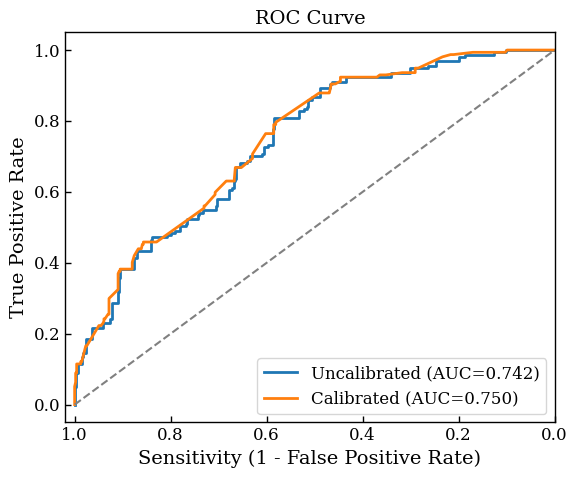

In [21]:
fpr_uncal, tpr_uncal, _ = roc_curve(y_test, y_prob_uncal)
fpr_cal,   tpr_cal,   _ = roc_curve(y_test, y_prob_cal)

plt.figure(figsize=(6,5))
plt.plot(1 - fpr_uncal, tpr_uncal, label=f"Uncalibrated (AUC={auc_uncal:.3f})", lw=2)
plt.plot(1 - fpr_cal,   tpr_cal,   label=f"Calibrated (AUC={auc_cal:.3f})", lw=2)
plt.plot([1.0, 0], [0, 1], "--", color="gray")
plt.xlim(1.02,0)
plt.xlabel("Sensitivity (1 - False Positive Rate)")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

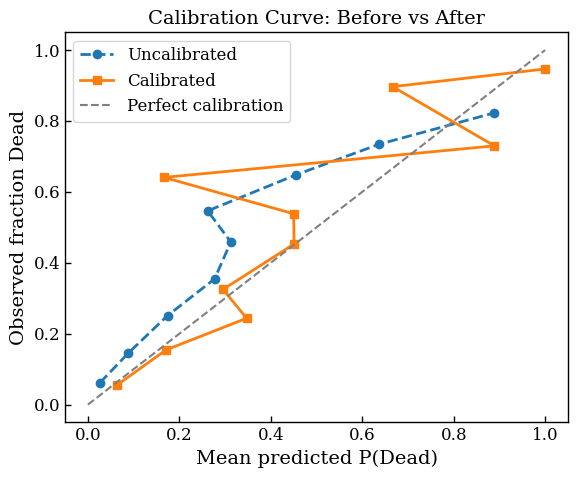

In [22]:
pt_uncal_x, pt_uncal_y = calibration_curve(y_test, y_prob_uncal, n_bins=10)
pt_cal_x,   pt_cal_y   = calibration_curve(y_test, y_prob_cal,   n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(pt_uncal_x, pt_uncal_y, "o--", label="Uncalibrated", lw=2)
plt.plot(pt_cal_x,   pt_cal_y,   "s-", label="Calibrated",   lw=2)
plt.plot([0,1], [0,1], "--", color="gray", label="Perfect calibration")
plt.xlabel("Mean predicted P(Dead)")
plt.ylabel("Observed fraction Dead")
plt.title("Calibration Curve: Before vs After")
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


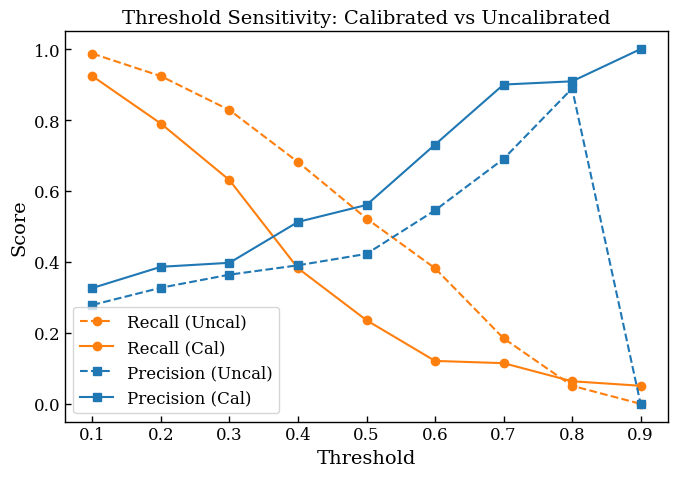

In [23]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.linspace(0.1, 0.9, 9)
records = []

for t in thresholds:
    unc_pred = (y_prob_uncal >= t).astype(int)
    cal_pred = (y_prob_cal   >= t).astype(int)

    p_unc, r_unc, _, _ = precision_recall_fscore_support(y_test, unc_pred, average="binary")
    p_cal, r_cal, _, _ = precision_recall_fscore_support(y_test, cal_pred, average="binary")

    records.append({
        "Threshold": t,
        "Precision_Uncal": p_unc,
        "Recall_Uncal":    r_unc,
        "Precision_Cal":   p_cal,
        "Recall_Cal":      r_cal
    })

df_thresh = pd.DataFrame(records)

plt.figure(figsize=(7,5))
plt.plot(df_thresh["Threshold"], df_thresh["Recall_Uncal"], "o--", label="Recall (Uncal)", color="C1")
plt.plot(df_thresh["Threshold"], df_thresh["Recall_Cal"],   "o-",  label="Recall (Cal)",   color="C1")

plt.plot(df_thresh["Threshold"], df_thresh["Precision_Uncal"], "s--", label="Precision (Uncal)", color="C0")
plt.plot(df_thresh["Threshold"], df_thresh["Precision_Cal"],   "s-",  label="Precision (Cal)",   color="C0")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sensitivity: Calibrated vs Uncalibrated")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
thr_default = 0.50
y_pred_50 = (y_prob_cal >= thr_default).astype(int)

print("\n=== Logistic model @ 0.50 threshold ===")
print(f"AUC  : {roc_auc_score(y_test, y_prob_cal):.3f}")
print(f"ACC  : {accuracy_score(y_test, y_pred_50):.3f}")
print(classification_report(y_test, y_pred_50,
      target_names=["Alive","Dead"]))


=== Logistic model @ 0.50 threshold ===
AUC  : 0.750
ACC  : 0.764
              precision    recall  f1-score   support

       Alive       0.79      0.94      0.86       475
        Dead       0.56      0.24      0.33       157

    accuracy                           0.76       632
   macro avg       0.67      0.59      0.59       632
weighted avg       0.73      0.76      0.73       632



In [25]:
from sklearn.utils import resample

n_bootstraps = 1000
rng = np.random.RandomState(1234)
boot_aucs = []
for _ in range(n_bootstraps):
    idxs = rng.choice(len(X_test), size=len(X_test), replace=True)
    y_boot = y_test.iloc[idxs]
    Xb    = X_test.iloc[idxs]
    Xb_trans = preproc.transform(Xb)
    prob = cal_model.predict_proba(Xb_trans)[:,1]
    boot_aucs.append(roc_auc_score(y_boot, prob))

ci_lower = np.percentile(boot_aucs, 2.5)
ci_upper = np.percentile(boot_aucs, 97.5)
print(f"Bootstrapped AUC 95% CI: {ci_lower:.3f}–{ci_upper:.3f}")

Bootstrapped AUC 95% CI: 0.709–0.791


In [26]:
# confusion matrix
cm    = confusion_matrix(y_test, y_pred_50)
cm_df = pd.DataFrame(cm,
                     index=["Alive","Dead"],
                     columns=["Alive","Dead"])
print("Confusion Matrix:\n", cm_df, "\n")
cm_df.to_csv(os.path.join(outdir,"Python_ConfusionMatrix_logistic.csv"))

Confusion Matrix:
        Alive  Dead
Alive    446    29
Dead     120    37 



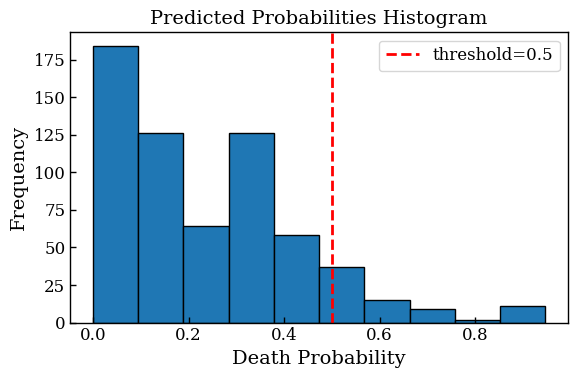

In [27]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(y_prob_cal, bins=10, edgecolor="k")
plt.axvline(0.5, color="red", linestyle="--", lw=2, label="threshold=0.5")
plt.title("Predicted Probabilities Histogram")
plt.xlabel("Death Probability")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(outdir,"Python_PredProb_histogram.png"))
plt.show()

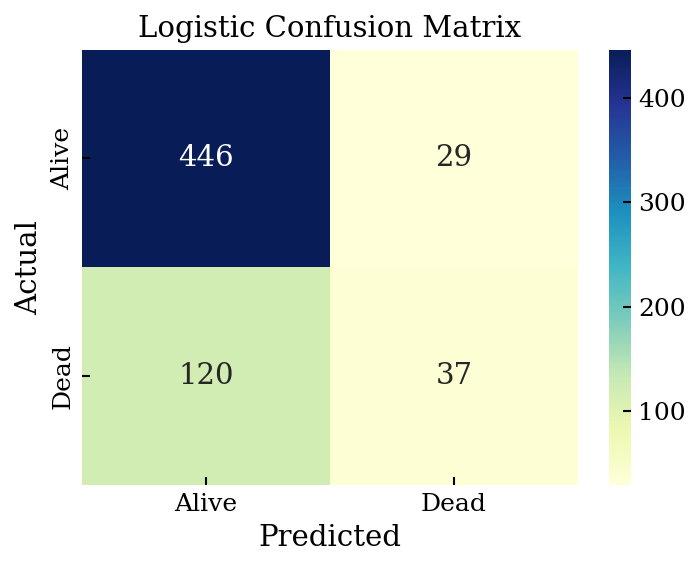

In [28]:
plt.figure(figsize=(5,4), dpi=150)
sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual"); plt.xlabel("Predicted")
plt.title("Logistic Confusion Matrix")
plt.tight_layout()
#plt.savefig(os.path.join(outdir,"ConfusionMatrix_logistic_heatmap.png"))
plt.show()

The smaller the **Brier score** loss, the better, hence the naming with “loss”. The **Brier score** measures the mean squared difference between the predicted probability and the actual outcome. The Brier score is a strictly  **scoring rule**.

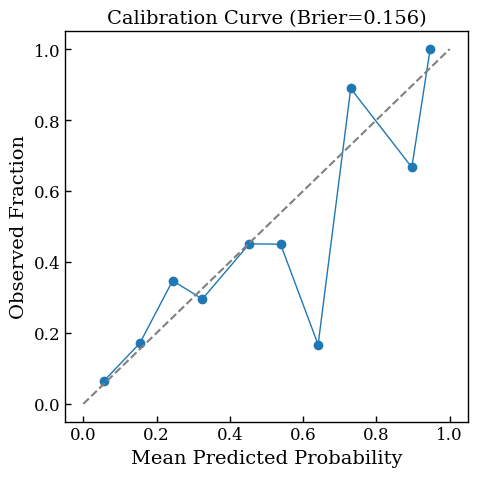

In [29]:
# calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_cal, n_bins=10)
brier = brier_score_loss(y_test, y_prob_cal)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Fraction")
plt.title(f"Calibration Curve (Brier={brier_score_loss(y_test, y_prob_cal):.3f})")
plt.tight_layout()
plt.show()

In [30]:
# ─────────────────────────────────────────────────────────────
#  Iterative optimum‑threshold search 
# ─────────────────────────────────────────────────────────────

def find_opt_thr(y_true, y_prob_cal, fn_cost, fp_cost,
                 zoom=(0.05, 0.01, 0.002)):
    lo, hi = 0.0, 1.0
    best_thr, best_cost = None, np.inf

    def cost(cm):
        tn, fp, fn, tp = cm.ravel()
        return fp*fp_cost + fn*fn_cost

    for step in zoom:
        grid = np.arange(lo, hi+step/2, step)
        vals = []
        for t in grid:
            y_pred = (y_prob_cal >= t).astype(int)
            cm = confusion_matrix(y_true, y_pred)
            vals.append(cost(cm))
        idx = int(np.argmin(vals))
        best_thr = grid[idx]
        best_cost = vals[idx]
        lo, hi = max(0, best_thr-step), min(1, best_thr+step)

    return best_thr, best_cost

def net_benefit(y_true, y_prob_cal, pt):
    y_pred = (y_prob_cal >= pt).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    n = len(y_true)
    return (tp / n) - (fp / n) * (pt / (1 - pt))

In [31]:
ratios = (1, 2, 3, 4)

results = []
for ratio in ratios:
    thr, tot_cost = find_opt_thr(y_test, y_prob_cal,
                                 fn_cost=ratio, fp_cost=1)
    tn, fp, fn, tp = confusion_matrix(
        y_test, (y_prob_cal >= thr).astype(int)
    ).ravel()
    sens = round(tp / (tp + fn), 2)
    spec = round(tn / (tn + fp), 2)

    results.append({
        "FN:FP":      f"{ratio}:1",
        "Threshold":  round(thr, 3),
        "FP": fp,
        "FN": fn,
        "Total cost": int(tot_cost),
        "Sensitivity": sens,
        "Specificity": spec
    })

summary = pd.DataFrame(results)
summary

,FN:FP,Threshold,FP,FN,Total cost,Sensitivity,Specificity
0,1:1,0.686,2,139,141,0.11,1.00
1,2:1,0.328,68,85,238,0.46,0.86
2,3:1,0.192,197,33,296,0.79,0.59
3,4:1,0.126,263,12,311,0.92,0.45


In logistic regression, you need to **choose** between prioritizing **higher sensitivity or higher specificity**, as there's an inherent trade-off between the two. A model with **high sensitivity is good at identifying all actual positive cases**, but it might also produce more false positives. Conversely, a model with **high specificity excels at correctly identifying negative cases**, but it might miss some actual positive cases, resulting in false negatives

In [32]:
from matplotlib.table import Table 

pts = np.linspace(0.01, 0.8, 100)
nb_model = np.array([net_benefit(y_test, y_prob_cal, t) for t in pts])

n_boot = 1000
rng = np.random.RandomState(1234)
boot_mat = np.empty((n_boot, len(pts)))

for i in range(n_boot):
    idx = rng.choice(len(y_test), size=len(y_test), replace=True)
    y_boot = y_test.iloc[idx]
    p_boot = y_prob_cal[idx]
    boot_mat[i, :] = [net_benefit(y_boot, p_boot, t) for t in pts]

low, high = np.percentile(boot_mat, [2.5, 97.5], axis=0)

offset_map = {
    "1:1": 0.05, "2:1": 0.07,
    "3:1": 0.04,  "4:1": 0.06,
}

# fallback offset
default_off = 0.03

event_rate = y_test.mean()
nb_all  = [event_rate - (1-event_rate)*(t/(1-t)) for t in pts]

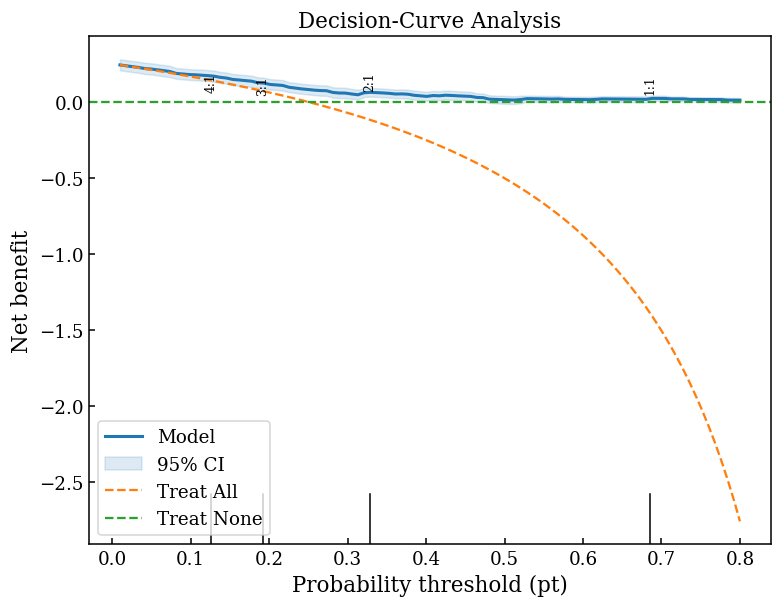

In [ ]:
plt.figure(figsize=(8,6), dpi=110)

# main lines
plt.plot(pts, nb_model, label="Model", lw=2, color="C0")
plt.fill_between(pts, low, high, color="C0", alpha=0.15,
                 label="95% CI")
plt.plot(pts, nb_all, "--", color="C1", label="Treat All")
plt.axhline(0, ls="--", color="C2", label="Treat None")

# ticks & labels for every ratio
for _, row in summary.iterrows():
    pt_star = row["Threshold"]
    lbl     = row["FN:FP"]
    plt.axvline(pt_star, ymin=0, ymax=0.1, color="black", lw=1)
    y_off = offset_map.get(lbl, default_off)
    plt.annotate(lbl, xy=(pt_star, y_off), xytext=(0,0),
                 textcoords="offset points", rotation=90,
                 va="bottom", ha="center", fontsize=8)
    

ax = plt.gca()
tbl = summary[["FN:FP", "FP", "FN"]].copy()
tbl.columns = ["Ratio", "FP", "FN"]
ax = plt.gca()
tbl_widget = Table(ax, bbox=[0.68, 0.55, 0.28, 0.35])

# header
for j, txt in enumerate(tbl.columns):
    tbl_widget.add_cell(0, j,
                        width = 0.09, height = 0.08,
                        text = txt,
                        loc = "center", facecolor = "#cccccc")

# data rows
for i, (_, r) in enumerate(tbl.iterrows(), start=1):
    for j, txt in enumerate(r):
        tbl_widget.add_cell(i, j,
                            width = 0.09, height = 0.08,
                            text = str(txt),
                            loc = "center")

plt.xlabel("Probability threshold (pt)")
plt.ylabel("Net benefit")
plt.title("Decision‑Curve Analysis")
plt.legend(loc="lower left")

# plt.savefig("decision_curve_polished.png")
plt.show()

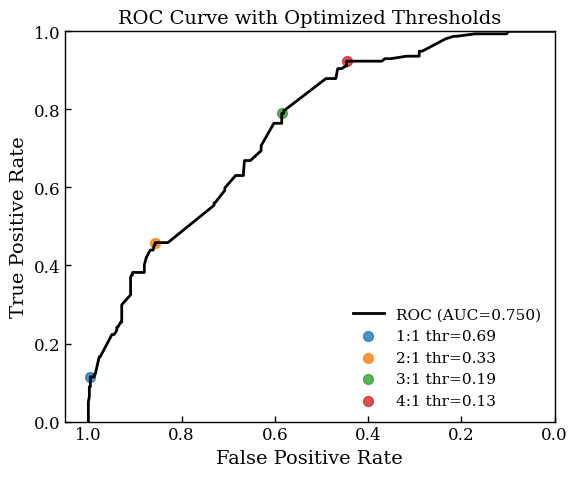

In [37]:
test_auc = roc_auc_score(y_test, y_prob_cal)

plt.figure(figsize=(6,5))
plt.plot(1-fpr_cal, tpr_cal, color="black", lw=2, label=f"ROC (AUC={test_auc:.3f})")

# scatter at (FPR, TPR)
for _, row in summary.iterrows():
    thr      = row["Threshold"]
    y_pred   = (y_prob_cal >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sens     = tp / (tp + fn)
    fpr_thr  = fp / (fp + tn)  # = 1 – spec

    plt.scatter(
        1-fpr_thr,
        sens,
        s=50,
        alpha=0.8,
        label=f"{row['FN:FP']} thr={thr:.2f}"
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimized Thresholds")
plt.xlim(1.05, 0)
plt.ylim(0, 1)
plt.legend(frameon = False, fontsize=11)
plt.tight_layout()
plt.show()


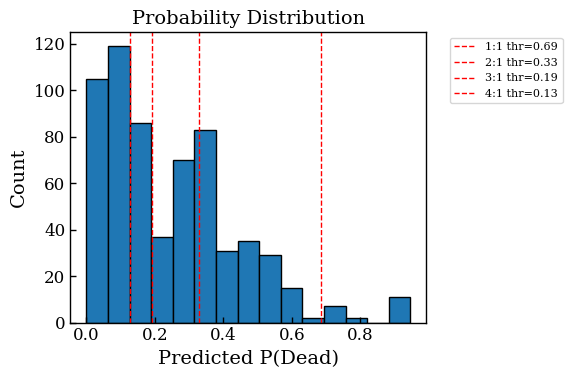

In [38]:
# 2) Histogram of predicted probabilities
plt.figure(figsize=(6,4), dpi=100)
plt.hist(y_prob_cal, bins=15, edgecolor="k")

for _, row in summary.iterrows():
    plt.axvline(row["Threshold"],
                linestyle="--", color="red", lw=1,
                label=f"{row['FN:FP']} thr={row['Threshold']:.2f}")

plt.xlabel("Predicted P(Dead)")
plt.ylabel("Count")
plt.title("Probability Distribution")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

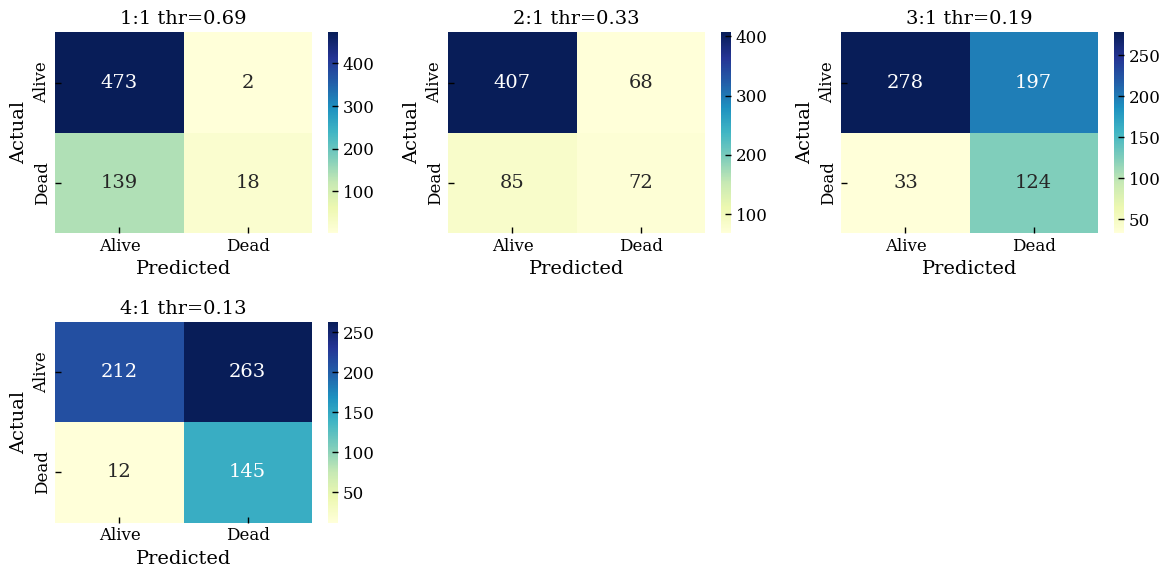

In [39]:
# 3) Confusion matrices—one per threshold
n = len(summary)
cols = 3
rows = (n + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), dpi=100)
axes = axes.flatten()

for ax, (_, row) in zip(axes, summary.iterrows()):
    thr = row["Threshold"]
    y_pred = (y_prob_cal >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Alive","Dead"], columns=["Alive","Dead"])
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu", cbar=True, ax=ax)
    ax.set_title(f"{row['FN:FP']} thr={thr:.2f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# turn off any unused subplots
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

- As the FN cost increases (from 1:1 to 4:1), the decision threshold drops — expected.

    - Lower thresholds result in more 'Dead' predictions, reducing false negatives (FN) and increasing true positives (TP), but at the expense of more false positives (FP).

- Model behavior is coherent:

     - At 1:1 (thr = 0.69): High specificity, low sensitivity.

     - At 2:1 to 4:1: Sensitivity increases, but specificity drops — a classic trade-off.


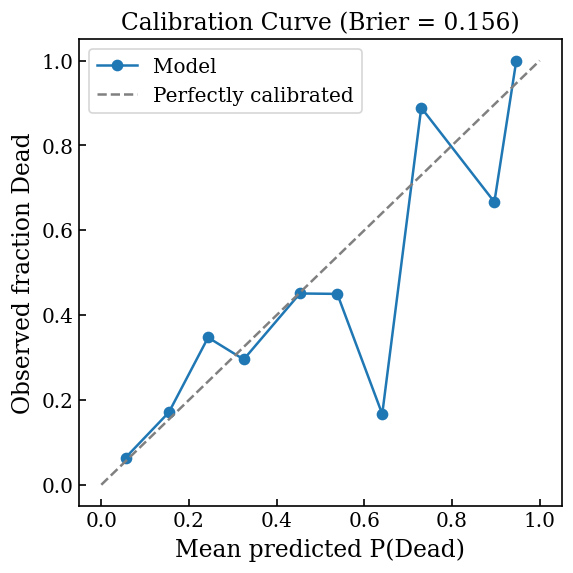

In [40]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_cal, n_bins=10)
brier = brier_score_loss(y_test, y_prob_cal)

plt.figure(figsize=(5,5), dpi=120)
plt.plot(prob_pred, prob_true, "o-", label="Model")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfectly calibrated")
plt.xlabel("Mean predicted P(Dead)")
plt.ylabel("Observed fraction Dead")
plt.title(f"Calibration Curve (Brier = {brier:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
from sklearn.metrics import precision_recall_fscore_support

records = []
for _, row in summary.iterrows():
    thr    = row["Threshold"]
    ratio  = row["FN:FP"]
    y_pred = (y_prob_cal >= thr).astype(int)

    p, r, f1, sup = precision_recall_fscore_support(
        y_test, y_pred, labels=[0,1]
    )
    records.append({
        "FN:FP":            ratio,
        "Threshold":        thr,
        "Precision_Alive":  p[0],
        "Recall_Alive":     r[0],
        "F1_Alive":         f1[0],
        "Support_Alive":    sup[0],
        "Precision_Dead":   p[1],
        "Recall_Dead":      r[1],
        "F1_Dead":          f1[1],
        "Support_Dead":     sup[1],
    })

report_df = pd.DataFrame.from_records(records)
print(report_df.round(3))


  FN:FP  Threshold  Precision_Alive  Recall_Alive  F1_Alive  Support_Alive  \
0   1:1      0.686            0.773         0.996     0.870            475   
1   2:1      0.328            0.827         0.857     0.842            475   
2   3:1      0.192            0.894         0.585     0.707            475   
3   4:1      0.126            0.946         0.446     0.607            475   

   Precision_Dead  Recall_Dead  F1_Dead  Support_Dead  
0           0.900        0.115    0.203           157  
1           0.514        0.459    0.485           157  
2           0.386        0.790    0.519           157  
3           0.355        0.924    0.513           157  


- 1:1 => Almost all alive cases caught but Dead recall is terrible

- 2:1 => More balanced — good Alive F1, and reasonable Dead F1

- 3:1 => Still decent, now Dead cases much better caught

- 4:1 => Dead recall is very high (92%), but too many false alarms (Alive recall down to 45%)

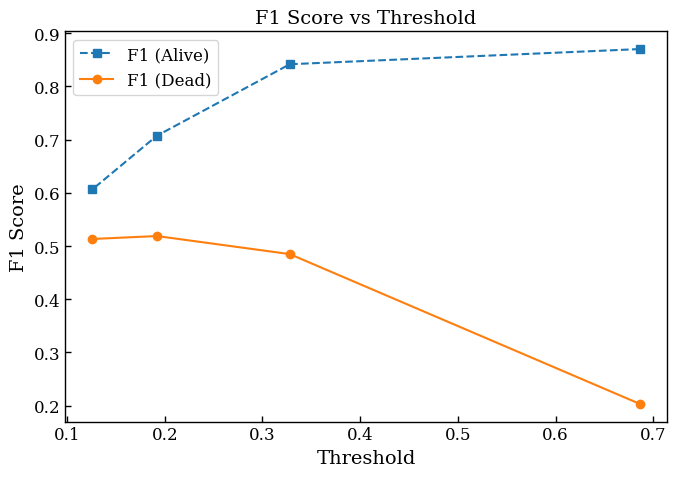

In [45]:
plt.figure(figsize=(7,5))
plt.plot(report_df["Threshold"], report_df["F1_Alive"], "s--", label="F1 (Alive)", color="C0")
plt.plot(report_df["Threshold"], report_df["F1_Dead"],  "o-",  label="F1 (Dead)",  color="C1")

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
thresholds = np.linspace(0.01, 0.99, 200)
best_thr = None
best_f1 = -np.inf

for t in thresholds:
    preds = (y_prob_cal >= t).astype(int)
    score = f1_score(y_test, preds, pos_label=1)
    if score > best_f1:
        best_f1 = score
        best_thr = t

print(f"Optimal threshold (max F1 for Dead): {best_thr:.3f}")
print(f"Max F1 score: {best_f1:.3f}")

Optimal threshold (max F1 for Dead): 0.182
Max F1 score: 0.520


In [47]:
def youden_j(t):
    preds = (y_prob_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    return sens + spec - 1

thresholds = np.linspace(0.01, 0.99, 200)
j_vals = [youden_j(t) for t in thresholds]
best_idx = np.argmax(j_vals)
best_thr = thresholds[best_idx]
print(f"Best Youden threshold: {best_thr:.3f}, J: {j_vals[best_idx]:.3f}")

Best Youden threshold: 0.182, J: 0.377
